# Compressed screen simulation

In [107]:
import numpy as np
from scipy.optimize import minimize, nnls, LinearConstraint, lsq_linear
import sklearn.linear_model as lm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import einops
import pandas as pd

import scipy.sparse as sparse

### Define the experiment parameters

In [144]:
num_markers = 100
num_measurements = 20
num_perturb = 50
num_bins = 3
num_cells = int(1e5)
seq_depth = 100000

gates_min = np.array([-np.inf, -0.6, 1])
gates_max = np.array([-1, 0.6, np.inf])
bin_code = np.array([-1,0, 1])

### Define the ground truth variables

- `D`: True effect size of each guide on expression, `num_perturb x num_markers`
- `S`: Guide assignment for single cells, `num_cells x num_perturb`

In [145]:
D = stats.norm.rvs(size=(num_perturb, num_markers))
D[np.absolute(D) < -0.5] = 0
# D[np.random.choice([True, False], p=[0.9, 0.1], size=D.shape)] = 0
S = np.zeros((num_cells, num_perturb))
for row in range(num_cells):
    S[row, np.random.randint(num_perturb)]=1
print('Sanity check, guide assignment per cell', S.sum(axis=1))

Sanity check, guide assignment per cell [1. 1. 1. ... 1. 1. 1.]


In [146]:
(D > 0).mean()

0.5128

### Generate single cells

Single cell expression

In [147]:
Z = stats.norm.rvs(S@D)

<AxesSubplot:ylabel='Density'>

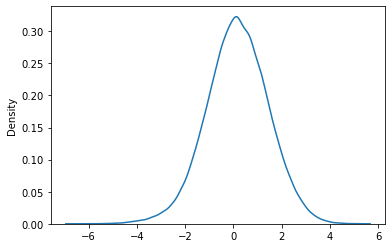

In [148]:
sns.kdeplot(Z[:, 0])

### Sort and sequence for "vanilla" screen

In [149]:
num_cells_per_measurement = int(num_cells/num_markers)

S_list = np.array_split(S, num_markers)
Z_list = np.array_split(Z, num_markers)

In [150]:
Y_vanilla = np.zeros((num_markers, num_bins, num_perturb))
meta_vanilla = []
for i in range(num_markers):
    
    for b in range(num_bins):
        
        meta_vanilla.append(('m'+str(i), bin_code[b]))
        
        cell_filter = (Z_list[i][:, i] > gates_min[b])& (Z_list[i][:, i] < gates_max[b])
        
        Y_vanilla[i,b,:] = S_list[i][cell_filter].mean(axis=0)
meta_vanilla = pd.DataFrame(meta_vanilla, columns=['marker', 'level'])  

### Solve vanilla case

In [151]:
def vanilla_screen(Y, meta):
    
    Y_flat = einops.rearrange(Y_vanilla, 'i j k -> (i j) k')
    X = pd.get_dummies(meta_vanilla[['marker']], prefix='', prefix_sep='')
    X = X[meta_vanilla['marker'].drop_duplicates()]
    X = X * meta_vanilla[['level']].values
    sns.heatmap(X)
    model = lm.LinearRegression(fit_intercept=False).fit(X,Y_flat)
    return model.coef_

Text(0.5, 0, 'Actual effect of guide on expression')

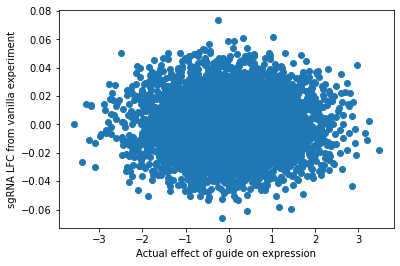

In [153]:
plt.scatter(D.ravel(),D_hat_vanilla.ravel())
plt.ylabel('sgRNA LFC from vanilla experiment')
plt.xlabel('Actual effect of guide on expression')


### Sort and sequence the "pooled" screen

In [154]:
num_markers_per_pool = 10
pooling_matrix = np.zeros((num_markers, num_measurements))
for idx in range(num_measurements):
    pooling_matrix[np.random.choice(num_markers, size=num_markers_per_pool, replace=False), idx] = 1
    

<AxesSubplot:ylabel='Density'>

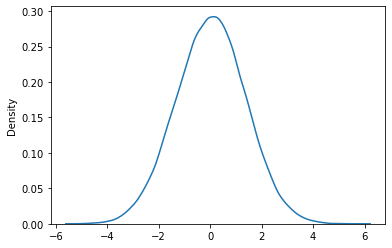

In [155]:
num_cells_per_measurement = int(num_cells/num_measurements)

S_list = np.array_split(S, num_measurements)

Zp = Z@pooling_matrix/np.sqrt(num_markers_per_pool)
Zp_list = np.array_split(Zp, num_measurements)
sns.kdeplot(Zp[:, 0])

In [156]:
Y_pooled = np.zeros((num_measurements, num_bins, num_perturb))
meta_pooled = []
for i in range(num_measurements):
    
    for b in range(num_bins):
        
        meta_pooled.append((str(i), bin_code[b]))
        
        cell_filter = (Zp_list[i][:, i] > gates_min[b])& (Zp_list[i][:, i] < gates_max[b])
        
        Y_pooled[i,b,:] = S_list[i][cell_filter].mean(axis=0)
meta_pooled = pd.DataFrame(meta_pooled, columns=['measurement', 'level'])        

### Naive approch

There's essentially no signal. The "signal" comes from the part of the vanilla screen that's just noise.

In [157]:
def pooled_screen_naive(Y, meta):

    Y_flat = np.log(einops.rearrange(Y, 'i j k -> (i j) k')+1e-3)
    X = pooling_matrix[:, meta['measurement'].astype(int)].T
    X = X * meta[['level']].values
    sns.heatmap(X)
    model = lm.Lasso(alpha=0.05, fit_intercept=False)
    model.fit(X,Y_flat)
    return model.coef_

Text(0, 0.5, 'sgRNA LFC from pooled experiment')

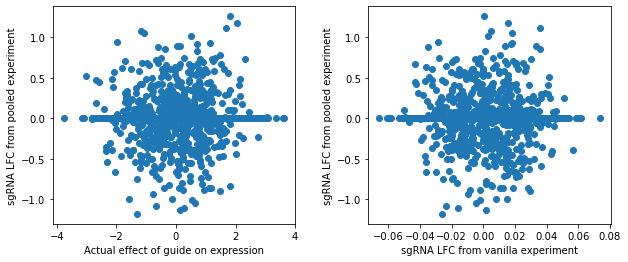

In [159]:
plt.figure(figsize=(10,4))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1, 2, 1)
plt.scatter(D.T.ravel(), D_hat_pooled.ravel())
plt.xlabel('Actual effect of guide on expression')
plt.ylabel('sgRNA LFC from pooled experiment')

plt.subplot(1, 2, 2)
plt.scatter(D_hat_vanilla.ravel(),D_hat_pooled.ravel())
plt.xlabel('sgRNA LFC from vanilla experiment')
plt.ylabel('sgRNA LFC from pooled experiment')


### Data augmentation approach

Pretend true expression is the bins. "Generate" data from the pseudobulks

In [ ]:
generated_data = []

for i in range(num_measurements):
    
    for b in range(num_bins):
        
        for p in range(num_perturb):
            
            

In [106]:
Y_pooled

array([[[1.58286778e-02, 1.24146493e-02, 1.35526588e-02, ...,
         1.34492034e-03, 1.44837575e-03, 2.79329609e-02],
        [1.31823696e-02, 1.80347756e-02, 1.56894460e-02, ...,
         5.24868581e-02, 4.20541852e-02, 6.38900121e-03]],

       [[4.08848018e-02, 2.27413943e-02, 4.97079657e-03, ...,
         1.88890270e-02, 1.64036287e-02, 2.88306201e-02],
        [4.06400813e-03, 9.27101854e-03, 2.17170434e-02, ...,
         9.46151892e-03, 1.27635255e-02, 5.96901194e-03]],

       [[1.90780654e-02, 1.29937094e-02, 3.71248840e-03, ...,
         1.22718367e-02, 1.90780654e-02, 1.12405899e-02],
        [1.07536207e-02, 1.76914405e-02, 3.55563264e-02, ...,
         2.09869049e-02, 1.27482439e-02, 1.82984997e-02]],

       ...,

       [[6.50374065e-02, 1.09725686e-03, 2.25436409e-02, ...,
         1.14713217e-02, 1.31670823e-02, 2.99251870e-02],
        [3.89226218e-04, 5.06772536e-02, 9.03004826e-03, ...,
         1.53355130e-02, 1.36229176e-02, 6.14977425e-03]],

       [[3.64646875

### Analyize vanilla screen

In [ ]:
Y_vanilla_flat = einops.rearrange(Y_vanilla, 'i j k -> (i j) k')
X_vanilla = 

In [157]:
Y_vanilla.shape

(15, 2, 100)

In [158]:
Y_pooled.shape

(5, 2, 100)

array([[0.00234742, 0.00234742, 0.00704225, ..., 0.00704225, 0.00469484,
        0.01877934],
       [0.00422833, 0.00634249, 0.00211416, ..., 0.01691332, 0.01057082,
        0.01268499],
       [0.0022779 , 0.00455581, 0.02050114, ..., 0.01138952, 0.01594533,
        0.00455581],
       ...,
       [0.        , 0.02455357, 0.01785714, ..., 0.00223214, 0.00892857,
        0.00223214],
       [0.02136752, 0.01282051, 0.        , ..., 0.01709402, 0.00854701,
        0.01709402],
       [0.        , 0.        , 0.02137767, ..., 0.0023753 , 0.00475059,
        0.00950119]])